# Extract RGB from PAD Columns

<font color='red'>Warning!</font> This notebook is a work in progress.

This notebook describes the process of extracting RGB colors from a PAD. Please remember to <font color='green'>change the settings</font> in the [User Inputs](#User-Inputs) section.

## Contents

- [User Inputs](#User-Inputs)
- [Imports](#Imports)
- [Load Images](#Load-Images)
- [Manual Box Placement](#Manual-Box-Placement)
- [Sample](#Sample)
- [Export to CSV](#Export-to-CSV)
- [Plot Color Changes Over Time](#Plot-Color-Changes-Over-Time)

## User Inputs

Change these variables.

In [19]:
INPUT_DIRECTORY = r"C:\Users\ericc\projects\padtools\raw_images"
OUTPUT_DIRECTORY = r"C:\Users\ericc\output_testing"
OUTPUT_PER_COLUMN_CSV = "columns.csv"
OUTPUT_PER_FILE_CSV = "summary.csv"

BOX_WIDTH = 50
BOX_HEIGHT = 600
NUM_BOXES = 12
OFFSET_TOP = 1300
OFFSET_LEFT = 540
HORIZONTAL_SPACER = 109

## Imports

In [20]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
from datetime import datetime

In [21]:
%matplotlib inline

## Load Images

In [22]:
output_dir = pathlib.Path(OUTPUT_DIRECTORY)
if not output_dir.is_dir():
    os.mkdir(str(output_dir))
    print("Created: {}".format(str(output_dir)))
else:
    print("Already exists: {}".format(str(output_dir)))

output_per_column_csv_path = pathlib.Path(os.path.join(os.getcwd(), OUTPUT_DIRECTORY, OUTPUT_PER_COLUMN_CSV))
print("Column output CSV: {}".format(str(output_per_column_csv_path)))
output_per_file_csv_path = pathlib.Path(os.path.join(os.getcwd(), OUTPUT_DIRECTORY, OUTPUT_PER_FILE_CSV))
print("Summary output CSV: {}".format(str(output_per_file_csv_path)))

Already exists: C:\Users\ericc\output_testing
Column output CSV: C:\Users\ericc\output_testing\columns.csv
Summary output CSV: C:\Users\ericc\output_testing\summary.csv


Let this take care of the rest.

In [23]:
image_filenames = [pathlib.Path(os.path.join(os.getcwd(), INPUT_DIRECTORY, x)) for x in os.listdir(INPUT_DIRECTORY) if x.endswith('.jpg')]
print("Found these files:\n{}".format("\n".join([str(x) for x in image_filenames])))

Found these files:
C:\Users\ericc\projects\padtools\raw_images\IMG_20190313_160509.jpg
C:\Users\ericc\projects\padtools\raw_images\IMG_20190313_160532.jpg
C:\Users\ericc\projects\padtools\raw_images\IMG_20190313_160600.jpg
C:\Users\ericc\projects\padtools\raw_images\IMG_20190313_160630.jpg
C:\Users\ericc\projects\padtools\raw_images\IMG_20190313_160700.jpg
C:\Users\ericc\projects\padtools\raw_images\IMG_20190313_160730.jpg
C:\Users\ericc\projects\padtools\raw_images\IMG_20190313_160801.jpg
C:\Users\ericc\projects\padtools\raw_images\IMG_20190313_160830.jpg
C:\Users\ericc\projects\padtools\raw_images\IMG_20190313_160900.jpg
C:\Users\ericc\projects\padtools\raw_images\IMG_20190313_160930.jpg
C:\Users\ericc\projects\padtools\raw_images\IMG_20190313_161000.jpg
C:\Users\ericc\projects\padtools\raw_images\IMG_20190313_161031.jpg
C:\Users\ericc\projects\padtools\raw_images\IMG_20190313_161101.jpg
C:\Users\ericc\projects\padtools\raw_images\IMG_20190313_161130.jpg
C:\Users\ericc\projects\padto

## Manual Box Placement

In [24]:
def sample_boxes(
    pathlib_filename,
    box_width=50,
    box_height=500,
    num_boxes=12,
    offset_top=1250,
    offset_left=560,
    horizontal_spacer=109,
    output_dir="output",
    draw=True,
    verbose=False
):
    column_data = []
    if verbose:
        print("Reading: {}".format(str(pathlib_filename)))
    image = cv2.imread(str(pathlib_filename))
    for x in range(num_boxes):
        # Define rectangle to sample.
        box_top_left_x = int(offset_left + horizontal_spacer * x + box_width * x)
        box_top_left_y = int(offset_top)
        box_bottom_right_x = int(box_top_left_x + box_width)
        box_bottom_right_y = int(offset_top + box_height)
        
        # Sample colors.
        pixels_in_box = image[box_top_left_y:box_bottom_right_y, box_top_left_x:box_bottom_right_x]
            
        average_color = pixels_in_box.mean(axis=0).mean(axis=0)

        # Not used, but this will save the cropped pixels used for sampling.
        # Would be cool to embed this into an output Excel.
        # cv2.imwrite("test.jpg", pixels_in_box)
        
        # Work out the date and time.
        _, date_string, time_string = pathlib_filename.stem.split('_')
        file_creation_date = datetime.strptime(date_string, "%Y%m%d")
        file_creation_time = datetime.strptime(time_string, "%H%M%S")
        file_creation_datetime = datetime.strptime(date_string + time_string, "%Y%m%d%H%M%S")
        
        # Additional color options.
        average_inverted_blue = 255 - average_color[0]
        average_inverted_green = 255 - average_color[1]
        average_inverted_red = 255 - average_color[2]
        grayscale_intensity = sum(average_color) / 3
        grayscale_intensity = (average_color[0] + average_color[1] + average_color[2]) / 3
        inverted_grayscale_intensity = 255 - grayscale_intensity
        
        # Save data from box.
        datum = {
            "Filename": str(pathlib_filename),
            "Column": x,
            "TopLeftX": box_top_left_x,
            "TopLeftY": box_top_left_y,
            "BottomRightX": box_bottom_right_x,
            "BottomRightY": box_bottom_right_y,
            "AverageBlue": average_color[0],
            "AverageGreen": average_color[1],
            "AverageRed": average_color[2],
            "AverageInvertedBlue": average_inverted_blue,
            "AverageInvertedGreen": average_inverted_green,
            "AverageInvertedRed": average_inverted_red,
            "GrayscaleIntensity": grayscale_intensity,
            "InvertedGrayscaleIntensity": inverted_grayscale_intensity,
            "Date": file_creation_date,
            "Time": file_creation_time,
            "Datetime": file_creation_datetime
        }
        column_data.append(datum)
        
        # If you want to draw.
        if draw:
            cv2.rectangle(
                image,
                (box_top_left_x, box_top_left_y),
                (box_bottom_right_x, box_bottom_right_y),
                (255, 0, 0),
                21
            )

    blue_described = pd.Series([x["AverageBlue"] for x in column_data]).describe()
    green_described = pd.Series([x["AverageGreen"] for x in column_data]).describe()
    red_described = pd.Series([x["AverageRed"] for x in column_data]).describe()
    
    inverted_blue_described = pd.Series([x["AverageInvertedBlue"] for x in column_data]).describe()
    inverted_green_described = pd.Series([x["AverageInvertedGreen"] for x in column_data]).describe()
    inverted_red_described = pd.Series([x["AverageInvertedRed"] for x in column_data]).describe()
    
    grayscale_intensity_described = pd.Series([x["GrayscaleIntensity"] for x in column_data]).describe()
    inverted_grayscale_intensity_described = pd.Series([x["InvertedGrayscaleIntensity"] for x in column_data]).describe()

    # Average of columns.
    summary_data = {
        "Filename": str(pathlib_filename),
        
        "BlueMean": blue_described["mean"],
        "BlueStd": blue_described["std"],
        "BlueMin": blue_described["min"],
        "Blue25%": blue_described["25%"],
        "Blue50%": blue_described["50%"],
        "Blue75%": blue_described["75%"],
        "BlueMax": blue_described["max"],
        "GreenMean": green_described["mean"],
        "GreenStd": green_described["std"],
        "GreenMin": green_described["min"],
        "Green25%": green_described["25%"],
        "Green50%": green_described["50%"],
        "Green75%": green_described["75%"],
        "GreenMax": green_described["max"],
        "RedMean": red_described["mean"],
        "RedStd": red_described["std"],
        "RedMin": red_described["min"],
        "Red25%": red_described["25%"],
        "Red50%": red_described["50%"],
        "Red75%": red_described["75%"],
        "RedMax": red_described["max"],
        
        "InvertedBlueMean": inverted_blue_described["mean"],
        "InvertedBlueStd": inverted_blue_described["std"],
        "InvertedBlueMin": inverted_blue_described["min"],
        "InvertedBlue25%": inverted_blue_described["25%"],
        "InvertedBlue50%": inverted_blue_described["50%"],
        "InvertedBlue75%": inverted_blue_described["75%"],
        "InvertedBlueMax": inverted_blue_described["max"],
        "InvertedGreenMean": inverted_green_described["mean"],
        "InvertedGreenStd": inverted_green_described["std"],
        "InvertedGreenMin": inverted_green_described["min"],
        "InvertedGreen25%": inverted_green_described["25%"],
        "InvertedGreen50%": inverted_green_described["50%"],
        "InvertedGreen75%": inverted_green_described["75%"],
        "InvertedGreenMax": inverted_green_described["max"],
        "InvertedRedMean": inverted_red_described["mean"],
        "InvertedRedStd": inverted_red_described["std"],
        "InvertedRedMin": inverted_red_described["min"],
        "InvertedRed25%": inverted_red_described["25%"],
        "InvertedRed50%": inverted_red_described["50%"],
        "InvertedRed75%": inverted_red_described["75%"],
        "InvertedRedMax": inverted_red_described["max"],
        
        "GrayscaleIntensityMean": grayscale_intensity_described["mean"],
        "GrayscaleIntensityStd": grayscale_intensity_described["std"],
        "GrayscaleIntensityMin": grayscale_intensity_described["min"],
        "GrayscaleIntensity25%": grayscale_intensity_described["25%"],
        "GrayscaleIntensity50%": grayscale_intensity_described["50%"],
        "GrayscaleIntensity75%": grayscale_intensity_described["75%"],
        "GrayscaleIntensityMax": grayscale_intensity_described["max"],
        
        "InvertedGrayscaleIntensityMean": inverted_grayscale_intensity_described["mean"],
        "InvertedGrayscaleIntensityStd": inverted_grayscale_intensity_described["std"],
        "InvertedGrayscaleIntensityMin": inverted_grayscale_intensity_described["min"],
        "InvertedGrayscaleIntensity25%": inverted_grayscale_intensity_described["25%"],
        "InvertedGrayscaleIntensity50%": inverted_grayscale_intensity_described["50%"],
        "InvertedGrayscaleIntensity75%": inverted_grayscale_intensity_described["75%"],
        "InvertedGrayscaleIntensityMax": inverted_grayscale_intensity_described["max"],
        
        "Date": file_creation_date,
        "Time": file_creation_time,
        "Datetime": file_creation_datetime
    }
            
    if draw:
        plt.figure()
        plt.imshow(image)
        output_filename = os.path.join(
            os.getcwd(),
            output_dir,
            pathlib_filename.stem + "_OUTPUT_20190317" + pathlib_filename.suffix
        )
        cv2.imwrite(output_filename, image)
        if verbose:
            print("Wrote: {}".format(output_filename))
    return column_data, summary_data

## Sample

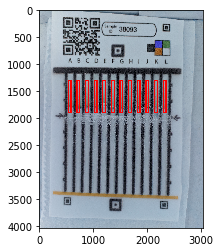

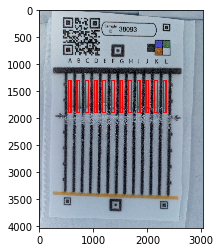

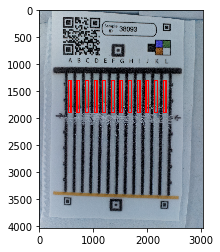

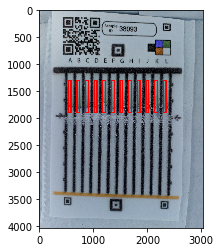

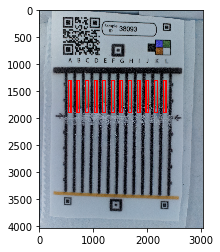

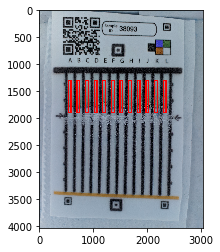

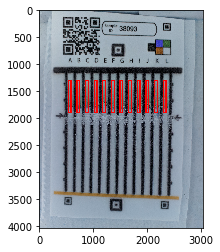

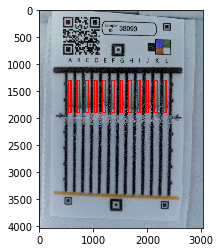

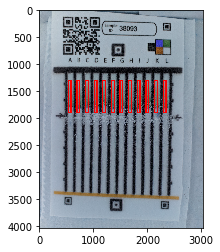

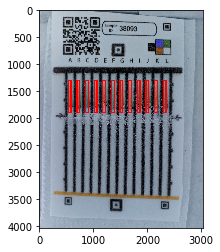

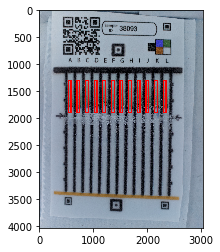

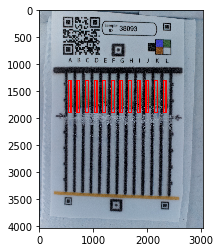

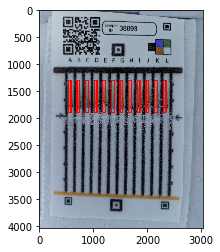

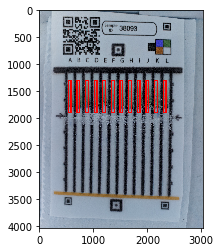

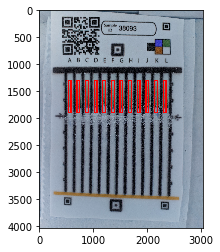

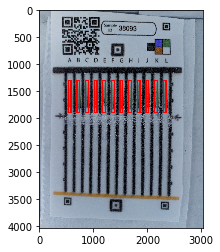

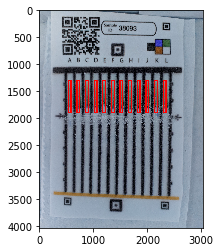

In [25]:
column_data = []
summary_data = []
for image_filename in image_filenames:
    column_data_from_this_file, summary_data_from_this_file = \
        sample_boxes(
            image_filename,
            output_dir=OUTPUT_DIRECTORY,
            verbose=False,
            draw=True,
            box_width=BOX_WIDTH,
            box_height=BOX_HEIGHT,
            num_boxes=NUM_BOXES,
            offset_left=OFFSET_LEFT,
            offset_top=OFFSET_TOP,
            horizontal_spacer=HORIZONTAL_SPACER
        )
    column_data.extend(column_data_from_this_file)
    summary_data.append(summary_data_from_this_file)

## Export to CSV

In [26]:
column_df = pd.DataFrame(column_data)
column_df["TimeDelta"] = column_df["Time"] - column_df["Time"].min()
column_df["TimeDelta"] = column_df["TimeDelta"].astype('timedelta64[s]')
column_df = column_df[[
    "Filename",
    "Column",
    "TopLeftX",
    "TopLeftY",
    "BottomRightX",
    "BottomRightY",
    "AverageBlue",
    "AverageGreen",
    "AverageRed",
    "AverageInvertedBlue",
    "AverageInvertedGreen",
    "AverageInvertedRed",
    "GrayscaleIntensity",
    "InvertedGrayscaleIntensity",
    "Date",
    "Time",
    "Datetime",
    "TimeDelta" 
]]

<font color='red'>Warning!</font> The cell below was used to select every other column. Comment or uncomment as needed!

In [27]:
# column_df = column_df.loc[column_df["Column"].isin([0, 2, 4, 6, 8, 10])]

In [28]:
column_df.to_csv(output_per_column_csv_path)

In [29]:
summary_df = pd.DataFrame(summary_data)
summary_df["TimeDelta"] = summary_df["Time"] - summary_df["Time"].min()
summary_df["TimeDelta"] = summary_df["TimeDelta"].astype('timedelta64[s]')
summary_df = summary_df[[
    "Filename",
    
    "BlueMean",
    "BlueStd",
    "BlueMin",
    "Blue25%",
    "Blue50%",
    "Blue75%",
    "BlueMax",
    "GreenMean",
    "GreenStd",
    "GreenMin",
    "Green25%",
    "Green50%",
    "Green75%",
    "GreenMax",
    "RedMean",
    "RedStd",
    "RedMin",
    "Red25%",
    "Red50%",
    "Red75%",
    "RedMax",
    
    "InvertedBlueMean",
    "InvertedBlueStd",
    "InvertedBlueMin",
    "InvertedBlue25%",
    "InvertedBlue50%",
    "InvertedBlue75%",
    "InvertedBlueMax",
    "InvertedGreenMean",
    "InvertedGreenStd",
    "InvertedGreenMin",
    "InvertedGreen25%",
    "InvertedGreen50%",
    "InvertedGreen75%",
    "InvertedGreenMax",
    "InvertedRedMean",
    "InvertedRedStd",
    "InvertedRedMin",
    "InvertedRed25%",
    "InvertedRed50%",
    "InvertedRed75%",
    "InvertedRedMax",
        
    "GrayscaleIntensityMean",
    "GrayscaleIntensityStd",
    "GrayscaleIntensityMin",
    "GrayscaleIntensity25%",
    "GrayscaleIntensity50%",
    "GrayscaleIntensity75%",
    "GrayscaleIntensityMax",
    
    "InvertedGrayscaleIntensityMean",
    "InvertedGrayscaleIntensityStd",
    "InvertedGrayscaleIntensityMin",
    "InvertedGrayscaleIntensity25%",
    "InvertedGrayscaleIntensity50%",
    "InvertedGrayscaleIntensity75%",
    "InvertedGrayscaleIntensityMax",
    
    "Date",
    "Time",
    "Datetime",
    "TimeDelta"
]]
summary_df.to_csv(output_per_file_csv_path)

## Plot Color Changes Over Time

In [30]:
summary_df.head()

,Filename,BlueMean,BlueStd,BlueMin,Blue25%,Blue50%,Blue75%,BlueMax,GreenMean,GreenStd,...,InvertedGrayscaleIntensityStd,InvertedGrayscaleIntensityMin,InvertedGrayscaleIntensity25%,InvertedGrayscaleIntensity50%,InvertedGrayscaleIntensity75%,InvertedGrayscaleIntensityMax,Date,Time,Datetime,TimeDelta
0,C:\Users\ericc\projects\padtools\raw_images\IM...,128.010067,2.764351,124.122800,126.492500,127.121583,129.214467,134.070900,146.866572,2.164165,...,2.743970,106.598978,110.952097,113.046450,114.198219,117.009056,2019-03-13,1900-01-01 16:05:09,2019-03-13 16:05:09,0.0
1,C:\Users\ericc\projects\padtools\raw_images\IM...,127.583864,2.849275,123.667433,125.496542,126.710867,128.909975,133.699400,146.635156,2.256729,...,2.900679,106.984011,111.358117,113.553589,114.870258,117.742089,2019-03-13,1900-01-01 16:05:32,2019-03-13 16:05:32,23.0
2,C:\Users\ericc\projects\padtools\raw_images\IM...,115.464044,3.135303,110.690733,113.535725,114.719633,117.251200,121.528300,134.206208,2.502656,...,3.215282,119.661056,123.564233,125.823056,127.234692,131.256511,2019-03-13,1900-01-01 16:06:00,2019-03-13 16:06:00,51.0
3,C:\Users\ericc\projects\padtools\raw_images\IM...,114.470694,3.371915,109.091900,112.477967,114.116400,116.419225,120.876233,133.293367,2.718635,...,3.481452,120.411700,124.525128,126.548967,128.278286,132.984700,2019-03-13,1900-01-01 16:06:30,2019-03-13 16:06:30,81.0
4,C:\Users\ericc\projects\padtools\raw_images\IM...,113.278731,3.529577,107.492133,111.315633,113.206883,115.114867,120.125700,132.284908,3.000370,...,3.735877,121.104644,125.786058,127.512733,129.354869,134.836156,2019-03-13,1900-01-01 16:07:00,2019-03-13 16:07:00,111.0


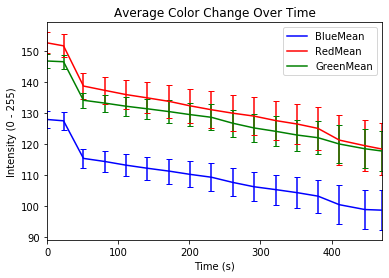

In [31]:
fig, ax = plt.subplots();
summary_df.plot(ax=ax, x="TimeDelta", y="BlueMean", yerr="BlueStd", capsize=3, color="blue");
summary_df.plot(ax=ax, x="TimeDelta", y="RedMean", yerr="RedStd", capsize=3, color="red");
summary_df.plot(ax=ax, x="TimeDelta", y="GreenMean", yerr="GreenStd", capsize=3, color="green");
ax.set_title("Average Color Change Over Time");
ax.set_ylabel("Intensity (0 - 255)");
ax.set_xlabel("Time (s)");

In [32]:
filename = output_dir / "average_color_intensity_over_time.png"
fig.savefig(str(filename))

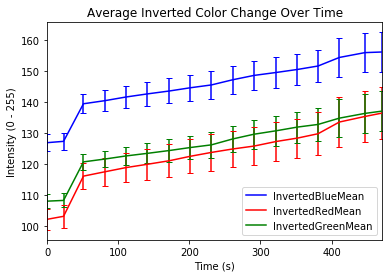

In [33]:
fig, ax = plt.subplots();
summary_df.plot(ax=ax, x="TimeDelta", y="InvertedBlueMean", yerr="InvertedBlueStd", capsize=3, color="blue");
summary_df.plot(ax=ax, x="TimeDelta", y="InvertedRedMean", yerr="InvertedRedStd", capsize=3, color="red");
summary_df.plot(ax=ax, x="TimeDelta", y="InvertedGreenMean", yerr="InvertedGreenStd", capsize=3, color="green");
ax.set_title("Average Inverted Color Change Over Time");
ax.set_ylabel("Intensity (0 - 255)");
ax.set_xlabel("Time (s)");

In [34]:
filename = output_dir / "average_inverted_color_intensity_over_time.png"
fig.savefig(str(filename))

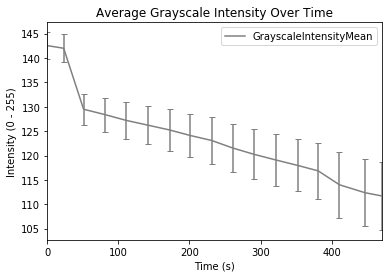

In [35]:
fig, ax = plt.subplots();
summary_df.plot(ax=ax, x="TimeDelta", y="GrayscaleIntensityMean", yerr="GrayscaleIntensityStd", capsize=3, color="gray");
ax.set_title("Average Grayscale Intensity Over Time");
ax.set_ylabel("Intensity (0 - 255)");
ax.set_xlabel("Time (s)");

In [36]:
filename = output_dir / "average_grayscale_intensity_over_time.png"
fig.savefig(str(filename))

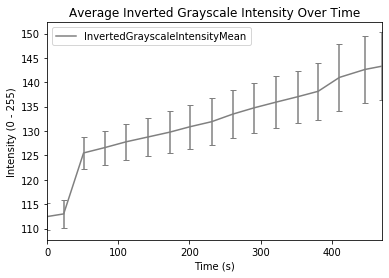

In [37]:
fig, ax = plt.subplots();
summary_df.plot(ax=ax, x="TimeDelta", y="InvertedGrayscaleIntensityMean", yerr="InvertedGrayscaleIntensityStd", capsize=3, color="gray");
ax.set_title("Average Inverted Grayscale Intensity Over Time");
ax.set_ylabel("Intensity (0 - 255)");
ax.set_xlabel("Time (s)");

In [38]:
filename = output_dir / "average_inverted_grayscale_intensity_over_time.png"
fig.savefig(str(filename))